## Finiding quasi-adaptive CRN with gradient-guided evolution

---

### Problem's setup

In [822]:
# Load libraries
include("CRNExplore.jl")
include("SymbolicOps.jl")

# fixed, basic steps

target = N
crn = create_reactions(N)
ode_crn = convert(ODESystem, crn)
np = count_parameters(N)

# set up hyperparameters

t0 = 10.
t1 = 20.
input = 1.
perturbation = 1.

# generate p0
pars_v = [rand() for i in 1:np]
pars_l = assemble_opt_parameters_and_varables(pars_v, N)

# set up the loss function
weights = [100., 1., 0.01, 5] #[1.0/50, 1.0, 1.0/80, 1.0] #[1., 0.01, 0.01, 1.] # this descends smoothly
p=0.01
d=0.5
f_ss=0.5

# finalize initialization

ext_ode = make_sensitivity_ode(ode_crn, pars_l.p)

norm_for_sensitivity_loss = 1
norm_for_ss_loss = 1
norm_for_adaptation_loss = 1
loss_args = prepare_args(nothing, target, t0, t1, pars_l, weights, p, d, f_ss, norm_for_sensitivity_loss, norm_for_ss_loss, norm_for_adaptation_loss)
s_loss = total_loss_symbolic(loss_args)
loss_derivatives = compute_symbolic_derivatives_of_loss(s_loss)

# set up optimization parameters

alpha = 0.1        # learning rate
N_iter = 100        # number of iterations

K = 5               # perturbation samples per iteration
perturbation_list = [-1., -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]

# output data structures
loss_tape = []
loss_tape_array = []
parameter_tape = []
gradient_tape = []
optimizer_tape = []

grad_history_ada = vec(zeros(length(pars_v)))
momentum_adam = vec(zeros(length(pars_v)))
velocity_adam = vec(zeros(length(pars_v)))
non_pruned_parameters = vec(ones(length(pars_v))) # implement heuristic to prune parameters

#push!(loss_tape, total_loss_eval(loss_args))
push!(parameter_tape, pars_v)
push!(gradient_tape, zeros(np))
push!(optimizer_tape, zeros(np))

# additional options
use_pruning_heuristic = true
clip_value = nothing
use_gradient_normalization = true
use_adagrad = true # overrides use_adam!
use_adam = false
use_random_perturbation = false

false

In [823]:
s_loss

(p_s - min(abs(-o_t0 + o_t0pdt), p_s))*w₁ + (1//2)*w₂*(abs(-at_t0_d₃ + at_t0₃) + abs(-at_t1_d₃ + at_t1₃) + abs(-at_t1_d₁ + at_t1₁) + abs(-at_t1_d₂ + at_t1₂) + abs(-at_t0_d₂ + at_t0₂) + abs(-at_t0_d₁ + at_t0₁)) + w₃*(abs(k_44) + abs(k_50) + abs(k_25) + abs(k_79) + abs(k_56) + abs(k_36) + abs(k_64) + abs(k_12) + abs(k_65) + abs(k_66) + abs(k_19) + abs(k_40) + abs(k_32) + abs(k_71) + abs(k_24) + abs(k_67) + abs(k_70) + abs(k_29) + abs(k_54) + abs(k_43) + abs(k_23) + abs(k_46) + abs(k_78) + abs(k_42) + abs(k_63) + abs(k_53) + abs(k_10) + abs(k_55) + abs(k_35) + abs(k_9) + abs(k_14) + abs(k_37) + abs(k_20) + abs(k_45) + abs(k_74) + abs(k_33) + abs(k_30) + abs(k_21) + abs(k_39) + abs(k_47) + abs(k_5) + abs(k_34) + abs(k_6) + abs(k_3) + abs(k_69) + abs(k_73) + abs(k_48) + abs(k_15) + abs(k_51) + abs(k_8) + abs(k_13) + abs(k_68) + abs(k_72) + abs(k_4) + abs(k_41) + abs(k_11) + abs(k_49) + abs(k_62) + abs(k_16) + abs(k_75) + abs(k_61) + abs(k_52) + abs(k_18) + abs(k_22) + abs(k_58) + abs(k_80) 

In [824]:
Symbolics.derivative(s_loss, o_t0)

-w₄*ifelse(signbit(-o_t0 + o_t1), -1, 1) + w₁*ifelse(abs(-o_t0 + o_t0pdt) < p_s, 1, 0)*ifelse(signbit(-o_t0 + o_t0pdt), -1, 1)

In [825]:
Symbolics.derivative(s_loss, o_t0pdt)

-w₁*ifelse(abs(-o_t0 + o_t0pdt) < p_s, 1, 0)*ifelse(signbit(-o_t0 + o_t0pdt), -1, 1)

In [826]:
Symbolics.derivative(s_loss, o_t1)

w₄*ifelse(signbit(-o_t0 + o_t1), -1, 1)

#### Training

In [827]:
# profiling @(100, 5) ~ 18s 
for i in 1:N_iter
    gradient = zeros(np) # zero the gradient
    loss_tape = push!(loss_tape, 0.)
    loss_tape_array = push!(loss_tape_array, zeros(n_losses))
    if use_random_perturbation
        for _ in 1:K
            # profiling @(100, 5) ~ 13.5s 
            sol = run_extended(ext_ode, pars_v, pars_l, input, perturbation, t0, t1)      # change to be more flexible in the perturbation events
            # profiling @(100, 5) ~ 0s 
            loss_args = update_args(sol, target, t0, t1, pars_l, loss_args, p, d, f_ss)   # prepare the input for the next step
            # profiling @(100, 5) ~ 3s
            loss = total_loss_eval(loss_args)
            loss_tape[end] += loss.total.val                        # record the loss
            loss_tape_array[end] += loss.array
            # symbolically "backpropagate"
            # profiling @(100, 5) ~ 3s
            jacobian = jacobian_pars(ext_ode, loss_args, loss_derivatives, sol, N, t0, t1, pars_v, f_ss, d, [[Symbol("x_$(i)") for i in 1:N]..., Symbol("U")])
            # profiling @(100, 5) ~ 1s
            gradient += vec([v.val for v in jacobian.sensitivity])  # check efficiency with symbolic operations (maybe we have to use "real" types directly)
        end
    else
        solutions = run_extended_with_fixed_perturbations(ext_ode, pars_l, input, perturbation_list, t0, t1)
        for sol in solutions
            loss_args = update_args(sol, target, t0, t1, pars_l, loss_args, p, d, f_ss)   # prepare the input for the next step
            loss = total_loss_eval(loss_args)
            loss_tape[end] = loss_tape[end] + loss.total.val              # record the loss
            loss_tape_array[end] = loss_tape_array[end] + loss.array
            # symbolically "backpropagate"
            jacobian = jacobian_pars(ext_ode, loss_args, loss_derivatives, sol, N, t0, t1, pars_v, f_ss, d, [[Symbol("x_$(i)") for i in 1:N]..., Symbol("U")])
            gradient += vec([v.val for v in jacobian.sensitivity])  # check efficiency with symbolic operations (maybe we have to use "real" types directly)
        end
    end
    if use_random_perturbation
        loss_tape[end] /= K # average the recorded loss
        loss_tape_array[end] ./= K
        gradient /= K       # average the gradient
    else
        loss_tape[end] /= length(perturbation_list) # average the recorded loss
        loss_tape_array[end] ./= length(perturbation_list)
        gradient /= length(perturbation_list)       # average the gradient
    end

    if use_pruning_heuristic 
        gradient = gradient .* non_pruned_parameters
    end

    if clip_value != nothing
        gradient = max.(min.(gradient, clip_value), -clip_value)
    end
    if use_gradient_normalization
        m = maximum(abs.(gradient))
        if m > 1.
            gradient /= m
        end
    end
    if use_adagrad
        lr = adagrad_update_get_coefficient(pars_v, gradient, grad_history_ada, alpha)
        push!(optimizer_tape, lr)
    elseif use_adam
        lr = ADAM_update_get_coefficient(pars_v, gradient, momentum_adam, velocity_adam, alpha, 0.9, 0.9, 1e-8)
        push!(optimizer_tape, lr)
    else
        lr = alpha
    end
    
    # update the parameters (avoid negative values) 
    
    if use_pruning_heuristic
        pars_v = max.(0., pars_v - (lr .* gradient)).*non_pruned_parameters
        non_pruned_parameters = (pars_v .> 0.0001)
    else
        pars_v = max.(0., pars_v - (lr .* gradient))
    end
    # update dictionary like parameters
    pars_l = assemble_opt_parameters_and_varables(pars_v, N) 
    
    push!(parameter_tape, pars_v)
    push!(gradient_tape, gradient)
end

### Plotting

---

##### Loss

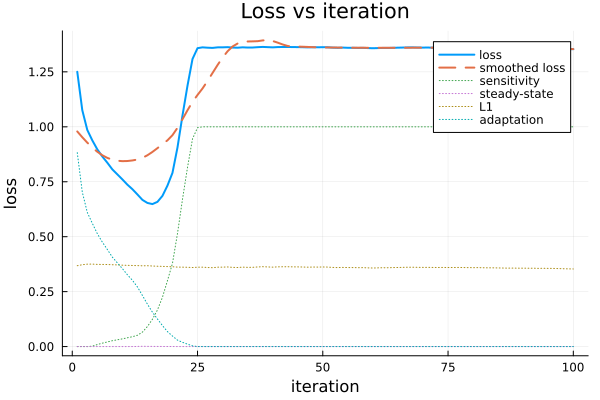

In [828]:
using Loess
loss_names = ["sensitivity", "steady-state", "L1", "adaptation"]
plot(1:length(loss_tape), loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:topright)
# smooth interpolation of the loss
model = loess(1:length(loss_tape), convert(Vector{Float64}, loss_tape), span=0.5)
predictions = predict(model, 1:length(loss_tape))
plot!(1:length(loss_tape), predictions, label="smoothed loss", lw=2, line=:dash)
for i in 1:n_losses
    #if sum([x[i].val for x in loss_tape_array]) > 0.
    plot!(1:length(loss_tape), [x[i].val for x in loss_tape_array], lw=1, line=:dot, label=loss_names[i])
    #end
end
plot!()

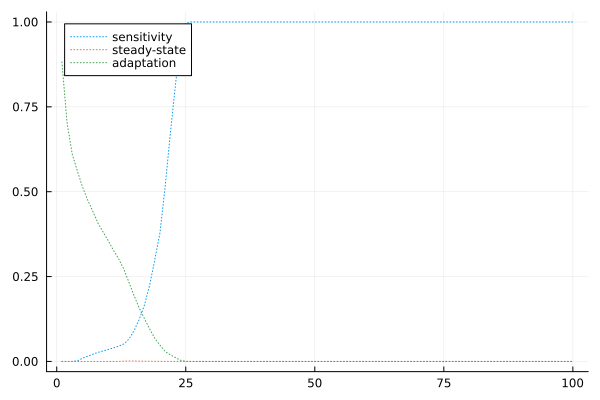

In [829]:
for i in 1:n_losses
    if i == 3
        continue
    end
    if i == 1
        plot(1:length(loss_tape), [x[i].val for x in loss_tape_array], lw=1, line=:dot, label=loss_names[i])
    else
        plot!(1:length(loss_tape), [x[i].val for x in loss_tape_array], lw=1, line=:dot, label=loss_names[i])
    end
end
plot!()

##### Response on best

Optimal index: 100
Adaptation error: 0.0
sensitivity: 0.0 and  loss : 0.01


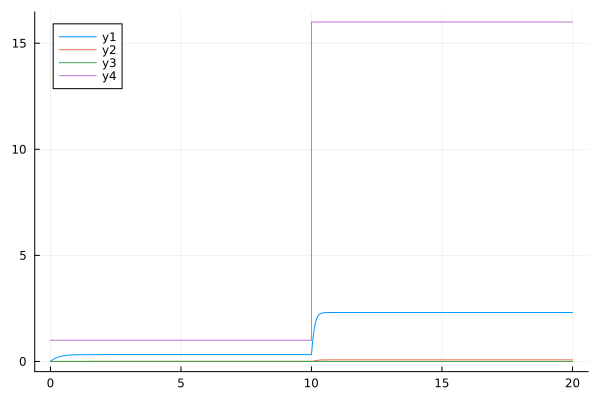

In [830]:
perturb = 15
opt_index = argmin(loss_tape)
opt_index = argmin(predictions)
opt_index = length(loss_tape) 
#opt_index = 10

opt_pars_v = parameter_tape[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+d)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+d)[3]) - p))
plot(sol.t, vec2mat(sol.u)[:,1:4])

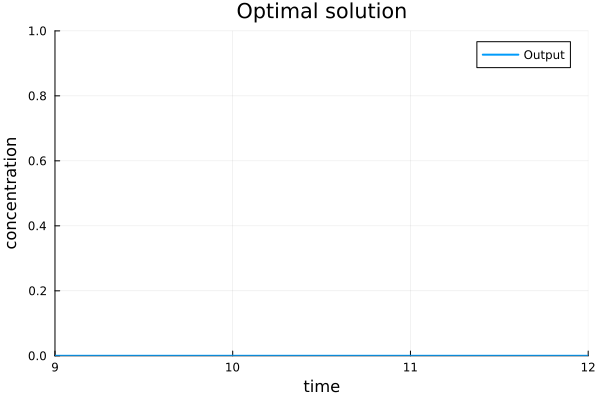

In [831]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="Output", xlabel="time", ylabel="concentration", title="Optimal solution", lw=2)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

compare the response on the 3rd species for the three options

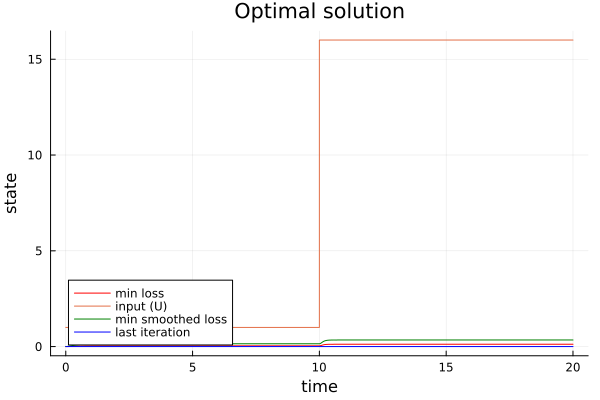

In [832]:
opt_index_options = [argmin(loss_tape), argmin(predictions), length(loss_tape)]
opt_index_options_labels = ["min loss", "min smoothed loss", "last iteration"]
opt_index_options_colors = [:red, :green, :blue]
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = parameter_tape[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)
    sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1]
    if i == 1
        plot(sol.t, vec2mat(sol.u)[:,3], label=opt_index_options_labels[i], xlabel="time", ylabel="state", title="Optimal solution", lw=1, legend=:bottomleft, color=opt_index_options_colors[i])
        plot!(sol.t, vec2mat(sol.u)[:,4], label="input (U)", lw=1, legend=:bottomleft)
    else
        plot!(sol.t, vec2mat(sol.u)[:,3], label=opt_index_options_labels[i], lw=1, legend=:bottomleft, color=opt_index_options_colors[i])
    end
end
plot!()

##### gradients

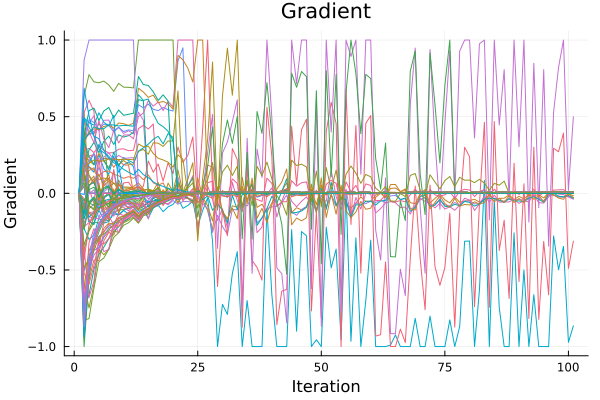

In [833]:
plot(1:length(gradient_tape), vec2mat(gradient_tape), legend=false, title="Gradient", xlabel="Iteration", ylabel="Gradient")

##### parameters

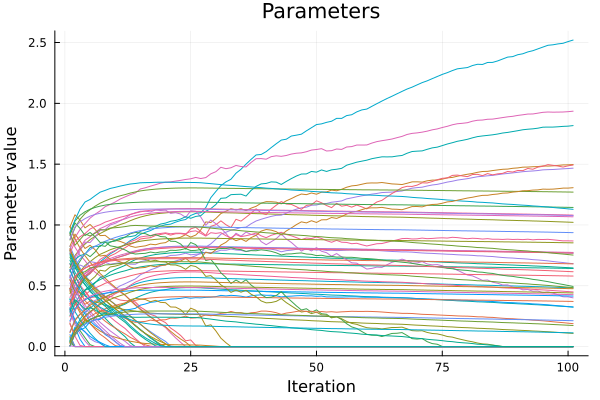

In [834]:
plot(1:length(parameter_tape), vec2mat(parameter_tape), legend=false, title="Parameters", xlabel="Iteration", ylabel="Parameter value")

prameter histogram

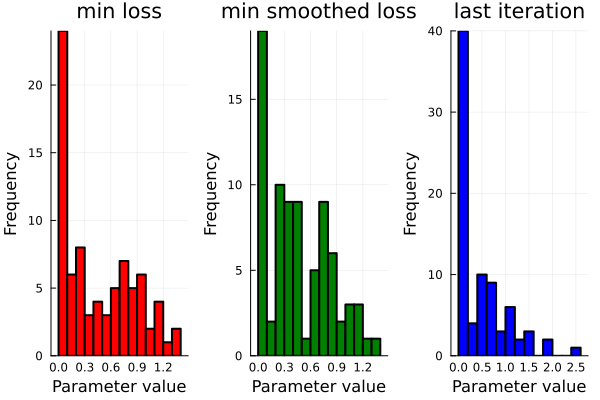

In [835]:
opt_index_options = [argmin(loss_tape), argmin(predictions), length(loss_tape)]
opt_index_options_labels = ["min loss", "min smoothed loss", "last iteration"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = parameter_tape[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

Adagrad lr

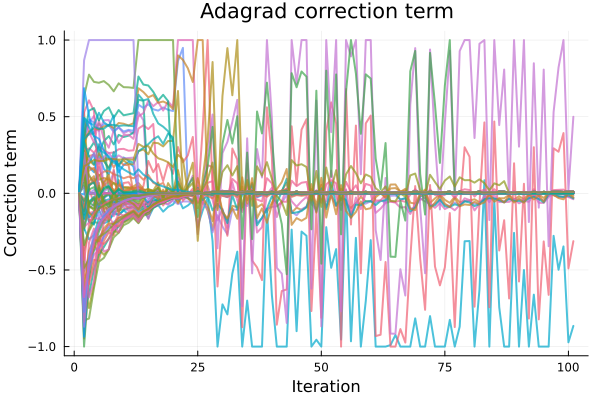

In [836]:
plot(1:length(gradient_tape), vec2mat(gradient_tape), label="Optimizer correction term", xlabel="Iteration", ylabel="Correction term", title="Adagrad correction term", lw=2, legend=false, alpha=0.7)

##### Evaluate adaptation type

In [846]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], unsym_dict(initial_conditions))
    return A_ij
end

opt_index = argmin(loss_tape)
# opt_index = argmin(predictions)
# opt_index = length(loss_tape)

opt_pars_v = parameter_tape[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

perturb = 1.
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1](t1)[1:3]
steady_state_after_perturbation = [
    :x_1 => steady_state_after_perturbation[1],
    :x_2 => steady_state_after_perturbation[2],
    :x_3 => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = 1.9263103334083536
A_32 = 0.07519887201392467
A_22 = -4.305791789534275
A_31 = 0.5935608677992407
A_22*A_31 = -2.55574951115881
A_21*A_32 = 0.14485636422107534
A_22*A_31 - A_21*A_32 = -2.7006058753798854


In [847]:
Symbolics.substitute(jac, unsym_dict(steady_state_after_perturbation))

3×4 Matrix{Num}:
 -6.36124    0.240191    1.34079  1
  1.92631   -4.30579     4.79325  0
  0.593561   0.0751989  -9.25543  0

In [848]:
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, input, [ perturb ], t0, t1)[1](t1)[1:3]

3-element Vector{Float64}:
 0.5757237904560251
 0.3540853599758961
 0.05505673995412377

In [849]:
# TODO to be fixed
compute_homeostatic_coefficient(crn, calculate_jacobian(ode_crn), [1 for i in 1:np])

(coefficient = -419.54327612949135, A_21 = 10.244398556978787, A_32 = 10.244398556975291, A_22 = -30.709033096051662, A_31 = 10.244398556975291, A_22_A_31 = -314.5955743352981, A_21_A_32 = 104.94770179419324)